<a href="https://colab.research.google.com/github/PAYAL980/Tensor-Network-for-Machine-Learning/blob/main/Explanatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensornetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 22.9 MB/s eta 0:00:00


In [3]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
import time

## A small example

In [4]:
# Initializing the tensors for the variational MPS and exemplary input tensors

L = 15            # number of pixels
weights = []


    # first tensor has only two indices
weights.append(tf.Variable(np.float32(np.eye(2,2)+np.random.normal(0,1e-2,size=(2, 2))), trainable=True))

    # all middle tensors have 3 indices
for i in range(L-2):
  weights.append(tf.Variable(np.float32([np.eye(2,2) for iz in range(2)]+np.random.normal(0,1e-2,size=(2,2,2))), trainable=True))

    # last tensor will have output, so it will hold 3 indices
weights.append(tf.Variable(np.float32([np.eye(2,10) for iz in range(2)]+np.random.normal(0,1e-2,size=(2, 2, 10))), trainable=True))

# examplary input
input_feature_map = []

for i in range(L):
  input_feature_map.append(tf.Variable(tf.random.uniform(shape=(2,), minval=0, maxval=1)))

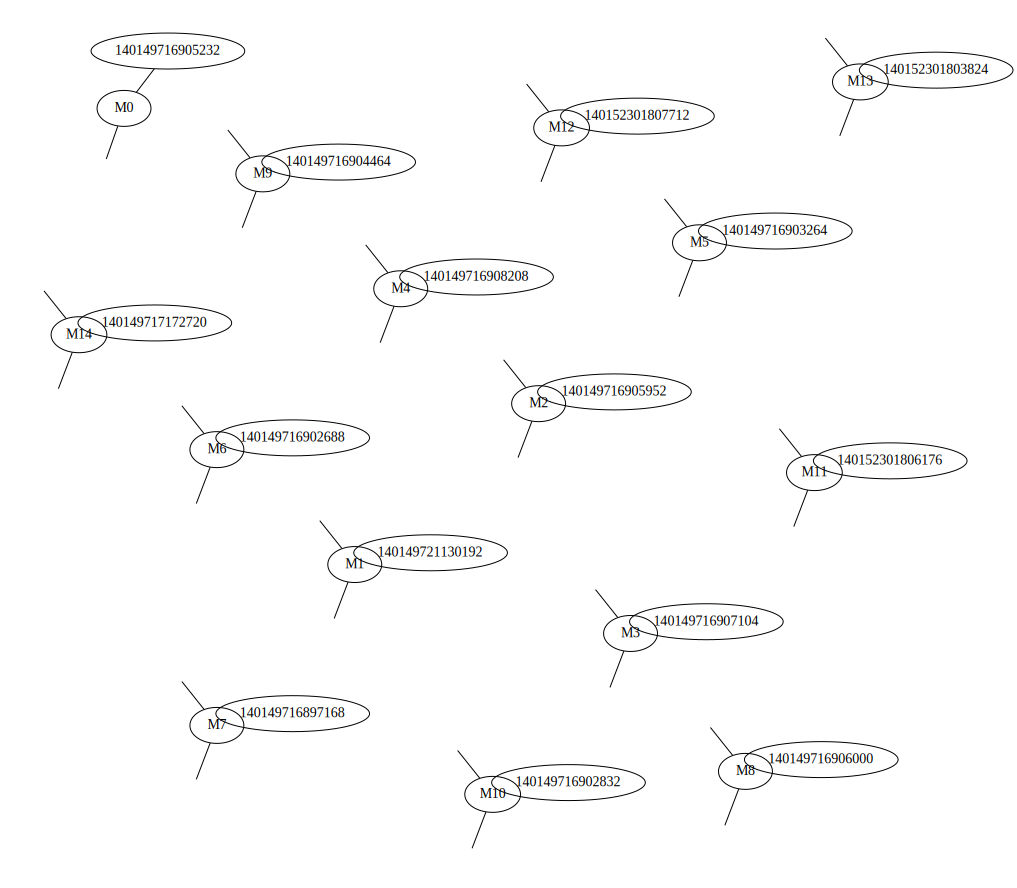

In [5]:
input_tensors = []
mps = []
cntrct = []

# creating data tensor and mps nodes and connecting to each other
for iz in range(L):
  input_tensors.append(tn.Node(input_feature_map[iz], name = f'I{iz}'))
  mps.append(tn.Node(weights[iz], name=f'M{iz}'))

  input_tensors[iz][0]^mps[iz][0]


tn.to_graphviz(mps)

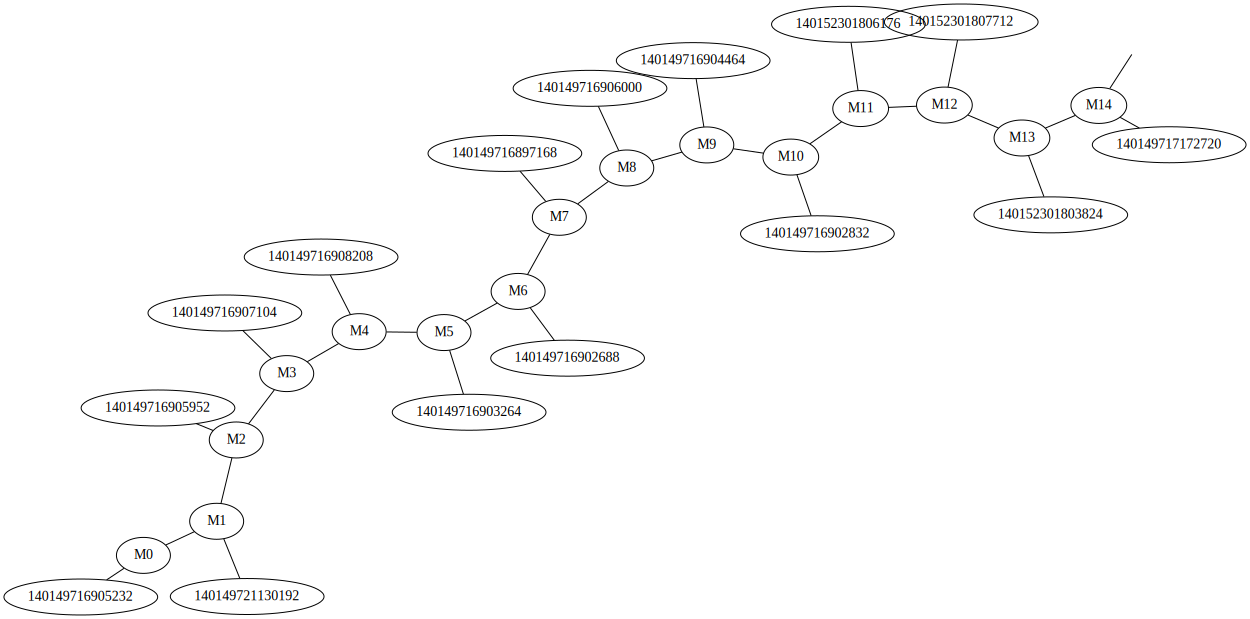

In [6]:
# one way is to connect the mps and then contract input_tensors and mps tensors
# look how M13 has an extra index, it will be used for classification

# Function to connect the mps

def connect_mps(mps, num_inds):
  for iz in range(len(mps)):

    if iz==0:
      mps[iz][num_inds-2]^mps[iz+1][num_inds-2]

    if iz!=0 and iz!=len(mps)-1:
      mps[iz][num_inds-1]^mps[iz+1][num_inds-2]

  return mps


mps = connect_mps(mps, num_inds=3)

tn.to_graphviz(mps)

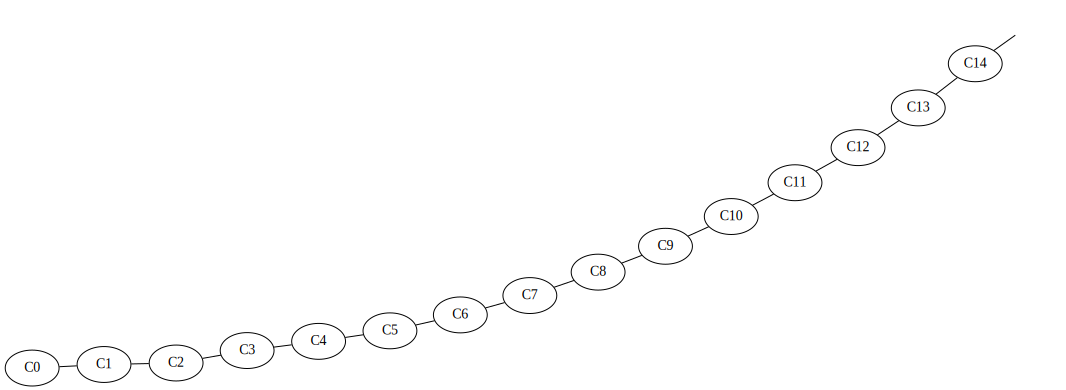

In [7]:
# And now contracting the nodes

def contract_data(a,b):
  return (a@b).tensor

c = [tn.Node(contract_data(input_tensors[iz], mps[iz]), name=f'C{iz}') for iz in range(L)]

mps_new = connect_mps(c, num_inds=2)

tn.to_graphviz(c)


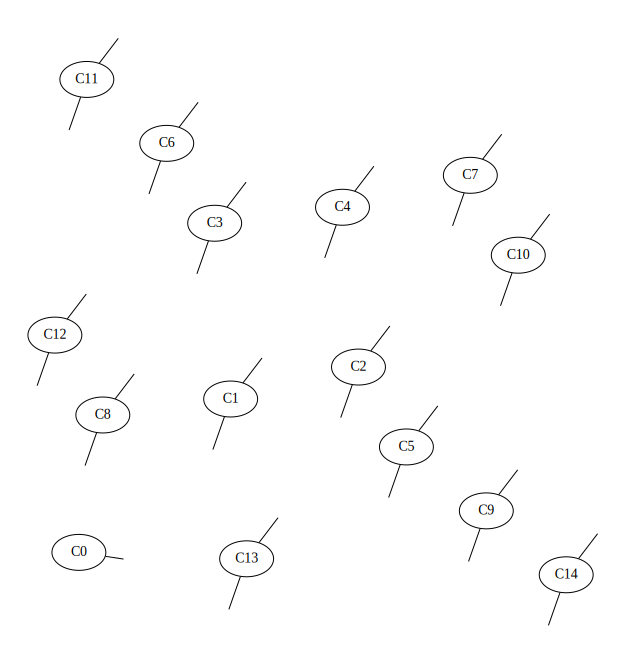

In [8]:
# Another way is to contract the input tensors with the mps while connecting them

input_tensors = []
mps = []
cntrct = []

# creating data tensor and mps nodes and connecting to each other
for iz in range(L):
  input_tensors.append(tn.Node(input_feature_map[iz], name = f'I{iz}'))
  mps.append(tn.Node(weights[iz], name=f'M{iz}'))

  input_tensors[iz][0]^mps[iz][0]
  cntrct.append(tn.Node(contract_data(input_tensors[iz], mps[iz]), name=f'C{iz}'))


tn.to_graphviz(cntrct)

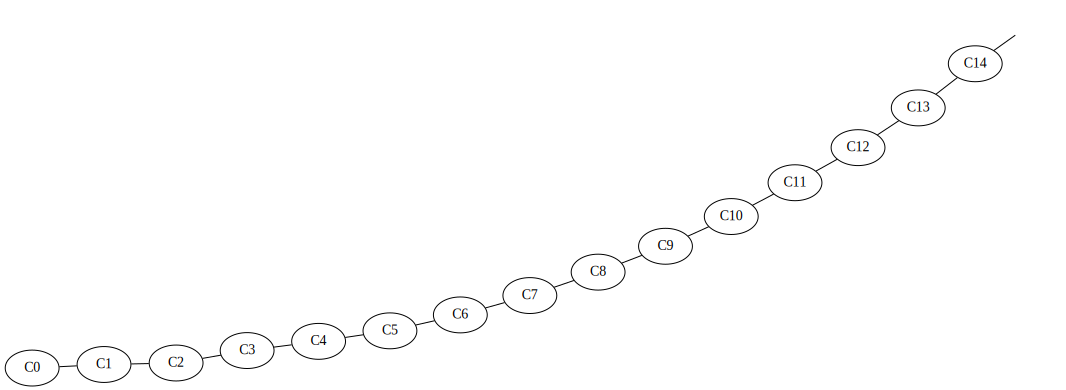

In [9]:
# connecting the mps

mps_new = connect_mps(cntrct, num_inds=2)
tn.to_graphviz(mps_new)

In [10]:
# Now we are at the same stage in both the approaches, now let's contract the nodes
while len(mps_new)!=3 and len(mps_new)!=2 :

        # steps = [2*n for n in range(len(mps_new)//2)]

        if len(mps_new)%2==1:
        # print(steps)
          mps_new = [tn.Node((mps_new[iz]@mps_new[iz+1]), name = f'R{iz}') for iz in range(0, len(mps_new)-1, 2)] + [tn.Node((mps_new[len(mps_new)-1]))]

        else:
          mps_new = [tn.Node((mps_new[iz]@mps_new[iz+1]), name = f'R{iz}') for iz in range(0, len(mps_new)-2, 2)]+[tn.Node((mps_new[len(mps_new)-2])), tn.Node((mps_new[len(mps_new)-1]))]

        # print('mps_done',len(mps_new))

        mps_new = connect_mps(mps_new, num_inds=2)


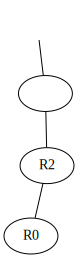

In [11]:
tn.to_graphviz(mps_new)

In [12]:
mps_new

[Node
 (
 name : 'R0',
 tensor : 
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.03342018, 0.03454738], dtype=float32)>,
 edges : 
 [
 Edge('R0'[0] -> 'R2'[0] )
 ] 
 ),
 Node
 (
 name : 'R2',
 tensor : 
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.9271973 , -0.03548415],
        [-0.00178469,  0.92785716]], dtype=float32)>,
 edges : 
 [
 Edge('R0'[0] -> 'R2'[0] )
 , 
 Edge('R2'[1] -> '__unnamed_node__'[0] )
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[ 1.2839394e+00,  7.5931982e-03,  2.8952579e-03,  5.8044912e-04,
          2.8356710e-03,  8.2246084e-03,  6.2166341e-03, -3.4404960e-03,
          9.1226604e-03, -2.3533464e-03],
        [ 4.2761415e-03,  1.2850499e+00,  1.4276326e-02, -3.4224615e-04,
         -7.1869162e-03,  7.7316277e-03, -5.5719279e-03,  3.6222022e-03,
         -3.0911579e-03, -1.9597515e-02]], dtype=float32)>,
 edges : 
 [
 Edge('R2'[1] -> '__unnamed_node__'[0] )
 , 
 Edge(D

In [ ]:
## Now the above two tensors can be contracted and final answer can be obtained